In [2]:
# %pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph


# !pip install -qU "langchain[openai]"
# !pip install -qU langchain-pinecone
# !pip install -qU langchain-mongodb
# !pip install beautifulsoup4
# !pip install pyarrow fastparquet
# !pip install ace_tools
# !pip install langsmith
# %pip install --upgrade --quiet  google-ai-generativelanguage==0.6.1
# %pip install --upgrade --quiet  langchain-google-genai 
# !pip install openpyxl
# !pip install -qU tqdm
# !pip install sentence-transformers    

In [ ]:
import pandas as pd
import re
# import ace_tools as tools
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore
# from .autonotebook import tqdm as notebook_tqdm
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain import hub
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
import langsmith
import getpass
import os
import json
from pydantic.v1 import BaseModel
from langchain.chat_models import init_chat_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
import getpass
import os
import re

from sentence_transformers import SentenceTransformer


c:\Users\hayde\OneDrive - Logical Aspect\Education\UniSA\INFT3039 - Capstone 1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Instructions for updating:
non-resource variables are not supported in the long term



In [ ]:
if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")



In [ ]:
#  load csv to dataframe
# df = pd.read_csv(r"C:\Users\hayde\University of South Australia\USO_Capstone Projects 2025 (SP1 SP3) - Group A - Group A\Assessment 1\Training Data\processed_dataset2_train_data_top100.csv")
# df.head()

# Define the GitHub raw CSV URL
csv_url = "https://github.com/haydenkerr/INFT3039-Capstone1-GroupA-25/raw/refs/heads/main/datasets/processed_dataset2_train_data.csv"
# Load the CSV data
df = pd.read_csv(csv_url)
df.columns


Index(['prompt', 'essay', 'evaluation', 'band', 'cleaned_evaluation',
       'Task Achievement', 'Coherence', 'Lexical Resource', 'Grammar',
       'Overall Band Score', 'word_count', 'sentence_count',
       'avg_sentence_length'],
      dtype='object')

In [6]:

# 'prompt', 'essay', 'evaluation', 'band', 'cleaned_evaluation','Task Achievement', 'Coherence', 'Lexical Resource', 'Grammar','Overall Band Score', 'word_count', 'sentence_count','avg_sentence_length'
df = df[['prompt', 'essay', 'band', 'cleaned_evaluation','Task Achievement', 'Coherence', 'Lexical Resource', 'Grammar','Overall Band Score']]  

df.rename(columns={'prompt':'question'}, inplace=True)



In [8]:


# Convert each row to a Document object from the dataframe
# if rows > 10 , then break for testing
docs = []
max_rows = 5000
processed_rows = 0
for _, row in df.iterrows():
    if processed_rows >= max_rows:
        break
    docs.append(
        Document(
            page_content=f"question: {row['question']}\nessay: {row['essay']}\nband: {row['band']} \ncleaned_evaluation: {row['cleaned_evaluation']}\nTask Achievement: {row['Task Achievement']}\nCoherence: {row['Coherence']}\nLexical Resource: {row['Lexical Resource']}\nGrammar: {row['Grammar']}\nOverall Band Score: {row['Overall Band Score']}"
        )
    )
    processed_rows += 1


# Initialize text splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Initialize embeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

# Initialize In-Memory Vector Store
vector_store = InMemoryVectorStore(embeddings)
vector_store.add_documents(all_splits)

# Load LLM and prompt
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")
prompt = hub.pull("rlm/rag-prompt")

# Define State for LLM workflow
class State(TypedDict):
    question: str
    essay: str
    context: List[Document]
    graded_response: str


In [54]:

# Retrieval function
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

# Grading function
def grade(state: State):
    example_texts = "\n\n".join(doc.page_content for doc in state["context"])
    user_input = f"New question: {state['question']}\nNew Essay: {state['essay']}"
    
    messages = [
        {"role": "system", "content": 
    """You are an IELTS examiner. Score the given essay based on the 0-9 IELTS band scale. 
    The output must be a **valid JSON object** with the following exact keys:
    - "question" (string): The original essay question.
    - "essay" (string): The given essay.
    - "overall_score" (float): A number between 0 and 9.
    - "overall_feedback" (string): Feedback on overall performance.
    - "task_achievement_score" (float): A number between 0 and 9.
    - "task_achievement_feedback" (string): Feedback on task achievement.
    - "coherence_score" (float): A number between 0 and 9.
    - "coherence_feedback" (string): Feedback on coherence.
    - "lexical_resource_score" (float): A number between 0 and 9.
    - "lexical_resource_feedback" (string): Feedback on lexical resource.
    - "grammar_score" (float): A number between 0 and 9.
    - "grammar_feedback" (string): Feedback on grammar.

    **Only return a valid JSON object with no extra text, explanations, or formatting.**"""},
        {"role": "user", "content": f"Here are some example graded essays:\n{example_texts}\n\nNow, evaluate this new essay:\n{user_input}"}
    ]
    
    response = llm.invoke(messages)
    return {"graded_response": response.content}

# Build Graph
graph_builder = StateGraph(State).add_sequence([retrieve, grade])

graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()



In [ ]:
# load test data set

# Define the GitHub raw CSV URL
csv_url_test = "https://github.com/haydenkerr/INFT3039-Capstone1-GroupA-25/raw/refs/heads/main/datasets/processed_dataset2_test_data.csv"
# Load the CSV data
df_test = pd.read_csv(csv_url_test)

df_test = df_test[['prompt', 'essay', 'band', 'cleaned_evaluation','Task Achievement', 'Coherence', 'Lexical Resource', 'Grammar','Overall Band Score']]  

df_test.rename(columns={'prompt':'question'}, inplace=True)

df_test.columns



Index(['question', 'essay', 'band', 'cleaned_evaluation', 'Task Achievement',
       'Coherence', 'Lexical Resource', 'Grammar', 'Overall Band Score'],
      dtype='object')

In [60]:
# Example test case
question_id = 13
# word wrap the text output below  
pd.set_option('display.max_colwidth',10 )


print("Question: "+df_test['question'][question_id])

print("Essay: "+df_test['essay'][question_id])
print("Overall Score: "+str(df_test["Overall Band Score"][question_id]))

new_question = df_test['question'][question_id]
new_essay = df_test['essay'][question_id]
print("---------")
 
# Run LLM grading
result = graph.invoke({"question": new_question, "essay": new_essay})
# print(result)
print("---------")
json_text = re.search(r"\{.*\}", result["graded_response"], re.DOTALL)
# print(json_text.group())
#  clean json_text to change all single quotes to double quotes
json_text = json_text.group() #.replace("'", '"')
#  convert string to json


if json_text:
    single_test_json = json.loads(json_text)
else:
    single_test_json = json.loads("{}")

 
print(json.dumps(single_test_json, indent=4, sort_keys=True))


Question: Some experts believe that when a country is already rich, any additional increase in economic wealth does not make its citizens any more satisfied. To what extent do you agree or disagree?
Essay: Nowadays, most people are more wealthy than in the past, which provide a better quality of lifestyle. However, it is argued that the extra income would not provide extra satisfaction. Personally, I agree with this stance, and the following content will outline the reasons.

Firstly, the function of money could lead to happiness. To have enough money, people have no need to have a busy and exhausted lives for earning money, meanwhile, they are also rescued from the financial pressure, such as house rent or bills. As a result, after obtaining enough money for living, people already satisfied, a higher amount is not essensial for their prosperity.

In addition, extra income could lead to extra payment. A higher salary means workers should pay more taxes from thier income to the country.

In [79]:
# for each row in the test data set, run the LLM grading
# Run LLM grading for 100 rows
rag_results = []
processed_rows = 0
for _, row in df_test.iterrows():
    if processed_rows >= 300:
        break
    result = graph.invoke({"question": row['question'], "essay": row['essay']})
    # add the results to the rag_results dataframe
    # print("Question: "+row['question']+ "\n")
    # print("Essay: "+row['essay']+ "\n")
    # print("Overall Score: "+str(row["Overall Band Score"])+ "\n")
    
    print("---------"+str(processed_rows))

    json_text = re.search(r"\{.*\}", result["graded_response"], re.DOTALL)
    # print(json_text)
    #  clean json_text to change all single quotes to double quotes
    json_text = json_text.group() #.replace("'", '"')
    #  convert string to json

    if json_text:
        result_json = json.loads(json_text)
    else:
        result_json = json.loads("{}")
        
   
 
    # print(json.dumps(single_test_json, indent=4, sort_keys=True))
    new_row = (row['question'],row['essay'],
               float(row["Overall Band Score"]),result_json["overall_score"],
               float(row["Overall Band Score"])/float(result_json["overall_score"]),
               row["cleaned_evaluation"], result_json["overall_feedback"],
               float(row["Task Achievement"]),result_json["task_achievement_score"],result_json["task_achievement_feedback"], 
               float(row["Coherence"]),result_json["coherence_score"],result_json["coherence_feedback"],
               float(row["Grammar"]),result_json["grammar_score"],result_json["grammar_feedback"],
               float(row["Lexical Resource"]),result_json["lexical_resource_score"],result_json["lexical_resource_feedback"]
               )

    rag_results.append(new_row)  
    processed_rows += 1


---------0
---------1
---------2
---------3
---------4
---------5
---------6
---------7
---------8
---------9
---------10
---------11
---------12
---------13
---------14
---------15
---------16
---------17
---------18
---------19
---------20
---------21
---------22
---------23
---------24
---------25
---------26
---------27
---------28
---------29
---------30
---------31
---------32
---------33
---------34
---------35
---------36
---------37
---------38
---------39
---------40
---------41
---------42
---------43
---------44
---------45
---------46
---------47
---------48
---------49
---------50
---------51
---------52
---------53
---------54
---------55
---------56
---------57
---------58
---------59
---------60
---------61
---------62
---------63
---------64
---------65
---------66
---------67
---------68
---------69
---------70
---------71
---------72
---------73
---------74
---------75
---------76
---------77
---------78
---------79
---------80
---------81
---------82
---------83
--

JSONDecodeError: Expecting property name enclosed in double quotes: line 14 column 1 (char 3601)

In [ ]:
rag_results

In [80]:

# convert list of dictionaries to dataframe
rag_results = pd.DataFrame(rag_results, columns = ['question','essay','Overall Band Score',
                                                   'Predicted Band Score','variation',
                                                   'cleaned_evaluation','Predicted Overall Feedback',
                                                   'Task Achievement','Predicted Task Achievement','Predicted Task Achievement Feedback',
                                                   'Coherence','Predicted Coherence','Predicted Coherence Feedback',
                                                   'Grammar','Predicted Grammar','Predicted Grammar Feedback',
                                                   'Lexical Resource','Predicted Lexical Resource','Predicted Lexical Resource Feedback'])


print(rag_results.shape) #42 rows, 5 columns
rag_results.head() # display the first 5 rows

(139, 19)


,question,essay,Overall Band Score,Predicted Band Score,variation,cleaned_evaluation,Predicted Overall Feedback,Task Achievement,Predicted Task Achievement,Predicted Task Achievement Feedback,Coherence,Predicted Coherence,Predicted Coherence Feedback,Grammar,Predicted Grammar,Predicted Grammar Feedback,Lexical Resource,Predicted Lexical Resource,Predicted Lexical Resource Feedback
0,Interv...,To agr...,6.5,6.5,1.000000,Task A...,The es...,6.5,7.0,The es...,7.0,7.0,The es...,6.5,6.5,The es...,6.5,6.0,The es...
1,The in...,It is ...,8.0,7.0,1.142857,Task A...,The es...,8.5,7.0,The es...,8.0,7.0,The es...,7.0,7.0,The es...,7.5,7.0,The es...
2,The in...,It is ...,8.5,6.0,1.416667,Task A...,The es...,8.5,6.0,The es...,8.0,6.5,The es...,7.0,6.0,The es...,7.5,6.0,The es...
3,The in...,The pr...,2.5,4.0,0.625000,Task A...,The es...,3.0,4.0,The es...,2.0,4.5,The es...,2.0,4.0,The gr...,2.5,4.0,The vo...
4,The in...,In rec...,4.0,6.0,0.666667,Task A...,The es...,3.5,6.0,The es...,4.0,6.5,The es...,3.5,6.0,The gr...,3.5,6.0,The vo...


In [81]:
# create measures of accuraacy for continuous data

# Mean Squared Error
# Root Mean Squared Error
# Mean Absolute Error

y_pred = rag_results['Predicted Band Score']
y_true = rag_results['Overall Band Score']

print("gemini_performance_measures")


print("mse")
mse = sqrt(mean_squared_error(rag_results['Overall Band Score'], rag_results['Predicted Band Score']))
print(mse)

print("rmse")
rmse = sqrt(mean_squared_error(rag_results['Overall Band Score'], rag_results['Predicted Band Score']))
print(rmse)

print("mae")
mae = mean_squared_error(rag_results['Overall Band Score'], rag_results['Predicted Band Score'])    
print(mae)




gemini_performance_measures
mse
1.2722833945199563
rmse
1.2722833945199563
mae
1.618705035971223


In [82]:
from sentence_transformers import util, SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

# print(df_test['cleaned_evaluation'][question_id])

# get the overall band score feedback between "Overall Band Score:" and "Feedback and Additional Comments:" from "cleaned_evaluation"
def get_band_score_feedback(cleaned_evaluation):
    start = "Overall Band Score:"
    end = "Feedback and Additional Comments:"
    return cleaned_evaluation[cleaned_evaluation.find(start)+len(start):cleaned_evaluation.rfind(end)]

def get_task_achievement_feedback(cleaned_evaluation):
    start = "Task Achievement:"
    end = "Coherence and Cohesion:"
    return cleaned_evaluation[cleaned_evaluation.find(start)+len(start):cleaned_evaluation.rfind(end)]

def get_coherence_feedback(cleaned_evaluation):
    start = "Coherence and Cohesion:"
    end = "Lexical Resource"
    return cleaned_evaluation[cleaned_evaluation.find(start)+len(start):cleaned_evaluation.rfind(end)]

def get_lexical_feedback(cleaned_evaluation):
    start = "Lexical Resource"
    end = "Grammatical Range "
    return cleaned_evaluation[cleaned_evaluation.find(start)+len(start):cleaned_evaluation.rfind(end)]

def get_grammar_feedback(cleaned_evaluation):
    start = "Grammatical Range "
    end = "Overall Band Score:"
    return cleaned_evaluation[cleaned_evaluation.find(start)+len(start):cleaned_evaluation.rfind(end)]

rag_results["Overall Feedback"] = rag_results.apply(lambda row: get_band_score_feedback(row["cleaned_evaluation"]), axis=1)
rag_results["Task Achievement Feedback"] = rag_results.apply(lambda row: get_task_achievement_feedback(row["cleaned_evaluation"]), axis=1)
rag_results["Coherence Feedback"] = rag_results.apply(lambda row: get_coherence_feedback(row["cleaned_evaluation"]), axis=1)
rag_results["Lexical Feedback"] = rag_results.apply(lambda row: get_lexical_feedback(row["cleaned_evaluation"]), axis=1)
rag_results["Grammar Feedback"] = rag_results.apply(lambda row: get_grammar_feedback(row["cleaned_evaluation"]), axis=1)


def compute_similarity(reference, candidate):
    ref_embedding = model.encode(reference, convert_to_tensor=True)
    cand_embedding = model.encode(candidate, convert_to_tensor=True)
    return util.cos_sim(ref_embedding, cand_embedding).item()

# Compute similarity for both models
rag_results["Overall Feedback Similarity"] = rag_results.apply(lambda row: compute_similarity((row["Overall Feedback"]), row["Predicted Overall Feedback"]), axis=1)
rag_results["Task Achievement Feedback Similarity"] = rag_results.apply(lambda row: compute_similarity((row["Task Achievement Feedback"]), row["Predicted Task Achievement Feedback"]), axis=1)
rag_results["Coherence Feedback Similarity"] = rag_results.apply(lambda row: compute_similarity((row["Coherence Feedback"]), row["Predicted Coherence Feedback"]), axis=1)
rag_results["Lexical Feedback Similarity"] = rag_results.apply(lambda row: compute_similarity((row["Lexical Feedback"]), row["Predicted Lexical Resource Feedback"]), axis=1)
rag_results["Grammar Feedback Similarity"] = rag_results.apply(lambda row: compute_similarity((row["Grammar Feedback"]), row["Predicted Grammar Feedback"]), axis=1)

# order the dataframe columns to make it easier to read
rag_results = rag_results[['question','essay','cleaned_evaluation',
                           'Overall Band Score','Predicted Band Score','variation',
                           'Overall Feedback','Predicted Overall Feedback','Overall Feedback Similarity',
                           'Task Achievement','Predicted Task Achievement','Task Achievement Feedback','Predicted Task Achievement Feedback','Task Achievement Feedback Similarity',
                           'Coherence','Predicted Coherence','Coherence Feedback','Predicted Coherence Feedback', 'Coherence Feedback Similarity',
                           'Lexical Resource','Predicted Lexical Resource','Lexical Feedback', 'Predicted Lexical Resource Feedback', 'Lexical Feedback Similarity',
                           'Grammar','Predicted Grammar','Grammar Feedback','Predicted Grammar Feedback', 'Grammar Feedback Similarity'
                           ]]


# Print average similarity
print("Average Overall Feedback Similarity:", rag_results["Overall Feedback Similarity"].mean())

# save to excel file
rag_results.to_excel("gemini_rag_results.xlsx")


Average Overall Feedback Similarity: 0.5153432668139823


In [83]:
rag_results.head() # display the first 5 rows

,question,essay,cleaned_evaluation,Overall Band Score,Predicted Band Score,variation,Overall Feedback,Predicted Overall Feedback,Overall Feedback Similarity,Task Achievement,...,Lexical Resource,Predicted Lexical Resource,Lexical Feedback,Predicted Lexical Resource Feedback,Lexical Feedback Similarity,Grammar,Predicted Grammar,Grammar Feedback,Predicted Grammar Feedback,Grammar Feedback Similarity
0,Interv...,To agr...,Task A...,6.5,6.5,1.000000,6.5\n...,The es...,0.748897,6.5,...,6.5,6.0,(6.0)...,The es...,0.673349,6.5,6.5,and Ac...,The es...,0.701410
1,The in...,It is ...,Task A...,8.0,7.0,1.142857,\n- Co...,The es...,0.241007,8.5,...,7.5,7.0,(Voca...,The es...,0.461214,7.0,7.0,and Ac...,The es...,0.500163
2,The in...,It is ...,Task A...,8.5,6.0,1.416667,\n\nCo...,The es...,0.422977,8.5,...,7.5,6.0,(Voca...,The es...,0.567277,7.0,6.0,and Ac...,The es...,0.482648
3,The in...,The pr...,Task A...,2.5,4.0,0.625000,\n- Th...,The es...,0.484285,3.0,...,2.5,4.0,(Voca...,The vo...,0.562913,2.0,4.0,and Ac...,The gr...,0.644655
4,The in...,In rec...,Task A...,4.0,6.0,0.666667,4\n- ...,The es...,0.692731,3.5,...,3.5,6.0,(Voca...,The vo...,0.615555,3.5,6.0,and Ac...,The gr...,0.554718


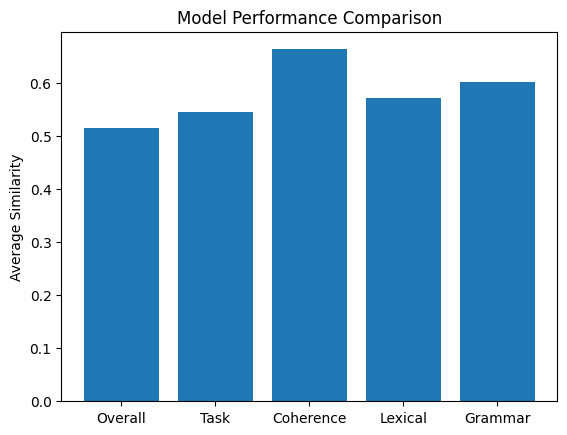

In [88]:
import matplotlib.pyplot as plt

# Plot similarity scores
plt.bar(["Overall", "Task","Coherence","Lexical","Grammar"], [rag_results["Overall Feedback Similarity"].mean(), rag_results["Task Achievement Feedback Similarity"].mean(), rag_results["Coherence Feedback Similarity"].mean(), rag_results["Lexical Feedback Similarity"].mean(), rag_results["Grammar Feedback Similarity"].mean()])
plt.ylabel("Average Similarity")
plt.title("Model Performance Comparison")
plt.show()